In [ ]:
import tensorflow

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Convolution2DTranspose
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
#warnings.filterwarnings("ignore")

In [ ]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.13.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

data_dir = '/content/drive/MyDrive/smile_dataset/2/dataset'

with zipfile.ZipFile(data_dir + '.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/image_dataset/2')

data_dir = '/tmp/image_dataset/2'

In [ ]:
path = data_dir
def create_training_data(path):
  dataX=[]
  dataY=[]
  # enumerate filenames in directory, assume all are images
  for root, subdirs, files in os.walk(path+"/dataset/neutral/"):
    #print(root, subdirs, files)
    for filename in files:
      file_path = os.path.join(root, filename)
      #print(file_path)
      file_path = file_path.replace('\\', '/')
      img_array=cv2.imread(file_path)
      print("neutral--"+file_path)
      #print(len(np.array(img_array)))
      new_array=cv2.resize(img_array,(128,64))
      dataX.append(new_array)
  # enumerate filenames in directory, assume all are images
  for root, subdirs, files in os.walk(path+"/dataset/smile/"):
    for filename in files:
      file_path = os.path.join(root, filename)
      file_path = file_path.replace('\\', '/')
      img_array=cv2.imread(file_path)
      print("smile--"+file_path)
      #print(img_array)
      new_array=cv2.resize(img_array,(128,64))
      dataY.append(new_array)
  return dataX,dataY

In [ ]:
IMG_SIZE = 128
dataX,dataY = create_training_data(path)
#dataX,dataY

neutral--/tmp/image_dataset/2/dataset/neutral/84.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/260.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/320.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/248.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/112.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/210.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/9.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/217.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/43.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/302.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/83.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/211.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/33.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/32.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/391.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/21.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/383.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/70.jpg
neutral--/tmp/image_dataset/2/dataset

In [ ]:
(np.array(dataX[0])).shape

(64, 128, 3)

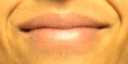

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(dataY[0])

In [ ]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.13.0


In [ ]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(64, 128, 3))

x=model_d.output

x = Convolution2DTranspose(512,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
x = Convolution2DTranspose(256,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
x = Convolution2DTranspose(256,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
x = Convolution2DTranspose(128,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
#x= GlobalAveragePooling2D()(x)
#x= BatchNormalization()(x)
#x= Dropout(0.5)(x)
#x= Dense(1024,activation='relu')(x)
#x= Dense(512,activation='relu')(x)
#x= BatchNormalization()(x)
#x= Dropout(0.5)(x)

preds=Convolution2DTranspose(3,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x) #FC-layer

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model=Model(inputs=model_d.input,outputs=preds)

for layer in model.layers[:-8]:
    layer.trainable=False

for layer in model.layers[-8:]:
    layer.trainable=True

# use tensorflow.keras.losses.KLDivergence() for KL-Div loss function
model.compile(optimizer='Adam',loss='mae',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 128, 3)]         0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 134, 3)           0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 32, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 32, 64, 64)           256       ['conv1/conv[0][0]']      

In [ ]:
dataX = np.array(dataX, dtype="float32") / 255.0
dataY = np.array(dataY, dtype="float32") / 255.0

In [ ]:
(xtrain,xtest,ytrain,ytest)=train_test_split(dataX,dataY,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(157, 64, 128, 3) (40, 64, 128, 3) (157, 64, 128, 3) (40, 64, 128, 3)


In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
model_path = "/content/drive/MyDrive/smile_dataset/2/dataset/DenseNet/model.h5"
checkpoint_path = "/content/drive/MyDrive/smile_dataset/2/dataset/DenseNet/checkpoint.ckpt"
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)

In [ ]:
#skip
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)
datagen.fit(xtrain)
# Fits-the-model

history = model.fit(xtrain,ytrain, batch_size=16,
               steps_per_epoch=xtrain.shape[0]//16,
               epochs=5000,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_split = 0.1,
               validation_steps = xtest.shape[0]//16)

Epoch 1/5000



Epoch 1: val_loss improved from inf to -0.85700, saving model to /content/drive/MyDrive/smile_dataset/2/dataset/DenseNet/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 - 30s - loss: 3.7643 - accuracy: 0.4250 - val_loss: -8.5700e-01 - val_accuracy: 0.3782 - lr: 0.0010 - 30s/epoch - 3s/step
Epoch 2/5000


9/9 - 0s - loss: -8.5931e-01 - accuracy: 0.3101 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 3/5000


9/9 - 0s - loss: -8.6647e-01 - accuracy: 0.2235 - lr: 0.0010 - 371ms/epoch - 41ms/step
Epoch 4/5000


9/9 - 0s - loss: -8.6677e-01 - accuracy: 0.2009 - lr: 0.0010 - 374ms/epoch - 42ms/step
Epoch 5/5000


9/9 - 0s - loss: -8.6688e-01 - accuracy: 0.1953 - lr: 0.0010 - 374ms/epoch - 42ms/step
Epoch 6/5000


9/9 - 0s - loss: -8.6692e-01 - accuracy: 0.1940 - lr: 0.0010 - 371ms/epoch - 41ms/step
Epoch 7/5000


9/9 - 0s - loss: -8.6694e-01 - accuracy: 0.1936 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 8/5000


9/9 - 0s - loss: -8.6695e-01 - accuracy: 0.1934 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 9/5000


9/9 - 0s - loss: -8.6697e-01 - accuracy: 0.1933 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 10/5000


9/9 - 0s - loss: -8.6698e-01 - accuracy: 0.1933 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 11/5000


9/9 - 0s - loss: -8.6699e-01 - accuracy: 0.1933 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 12/5000


9/9 - 0s - loss: -8.6699e-01 - accuracy: 0.1933 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 13/5000


9/9 - 0s - loss: -8.6700e-01 - accuracy: 0.1932 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 14/5000


9/9 - 0s - loss: -8.6701e-01 - accuracy: 0.1933 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 15/5000


9/9 - 0s - loss: -8.6702e-01 - accuracy: 0.1932 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 16/5000


9/9 - 0s - loss: -8.6703e-01 - accuracy: 0.1932 - lr: 0.0010 - 381ms/epoch - 42ms/step
Epoch 17/5000


9/9 - 0s - loss: -8.6704e-01 - accuracy: 0.1932 - lr: 0.0010 - 375ms/epoch - 42ms/step
Epoch 18/5000


9/9 - 0s - loss: -8.6705e-01 - accuracy: 0.1932 - lr: 0.0010 - 373ms/epoch - 41ms/step
Epoch 19/5000


9/9 - 0s - loss: -8.6706e-01 - accuracy: 0.1932 - lr: 0.0010 - 376ms/epoch - 42ms/step
Epoch 20/5000


9/9 - 0s - loss: -8.6707e-01 - accuracy: 0.1932 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 21/5000


9/9 - 0s - loss: -8.6708e-01 - accuracy: 0.1932 - lr: 0.0010 - 372ms/epoch - 41ms/step
Epoch 22/5000


9/9 - 0s - loss: -8.6709e-01 - accuracy: 0.1932 - lr: 0.0010 - 376ms/epoch - 42ms/step
Epoch 23/5000


9/9 - 0s - loss: -8.6709e-01 - accuracy: 0.1932 - lr: 0.0010 - 376ms/epoch - 42ms/step
Epoch 24/5000


9/9 - 0s - loss: -8.6710e-01 - accuracy: 0.1932 - lr: 0.0010 - 384ms/epoch - 43ms/step
Epoch 25/5000


9/9 - 0s - loss: -8.6711e-01 - accuracy: 0.1932 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 26/5000


9/9 - 0s - loss: -8.6712e-01 - accuracy: 0.1933 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 27/5000


9/9 - 0s - loss: -8.6713e-01 - accuracy: 0.1933 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 28/5000


9/9 - 0s - loss: -8.6714e-01 - accuracy: 0.1933 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 29/5000


9/9 - 0s - loss: -8.6714e-01 - accuracy: 0.1933 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 30/5000


9/9 - 0s - loss: -8.6715e-01 - accuracy: 0.1933 - lr: 0.0010 - 381ms/epoch - 42ms/step
Epoch 31/5000


9/9 - 0s - loss: -8.6716e-01 - accuracy: 0.1933 - lr: 0.0010 - 374ms/epoch - 42ms/step
Epoch 32/5000


9/9 - 0s - loss: -8.6717e-01 - accuracy: 0.1933 - lr: 0.0010 - 379ms/epoch - 42ms/step
Epoch 33/5000


9/9 - 0s - loss: -8.6718e-01 - accuracy: 0.1933 - lr: 0.0010 - 381ms/epoch - 42ms/step
Epoch 34/5000


9/9 - 0s - loss: -8.6718e-01 - accuracy: 0.1933 - lr: 0.0010 - 374ms/epoch - 42ms/step
Epoch 35/5000


9/9 - 0s - loss: -8.6719e-01 - accuracy: 0.1934 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 36/5000


9/9 - 0s - loss: -8.6720e-01 - accuracy: 0.1934 - lr: 0.0010 - 376ms/epoch - 42ms/step
Epoch 37/5000


9/9 - 0s - loss: -8.6721e-01 - accuracy: 0.1934 - lr: 0.0010 - 381ms/epoch - 42ms/step
Epoch 38/5000


9/9 - 0s - loss: -8.6721e-01 - accuracy: 0.1934 - lr: 0.0010 - 382ms/epoch - 42ms/step
Epoch 39/5000


9/9 - 0s - loss: -8.6722e-01 - accuracy: 0.1934 - lr: 0.0010 - 377ms/epoch - 42ms/step
Epoch 40/5000


9/9 - 0s - loss: -8.6723e-01 - accuracy: 0.1935 - lr: 0.0010 - 378ms/epoch - 42ms/step
Epoch 41/5000


9/9 - 0s - loss: -8.6723e-01 - accuracy: 0.1935 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 42/5000


9/9 - 0s - loss: -8.6724e-01 - accuracy: 0.1935 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 43/5000


9/9 - 0s - loss: -8.6725e-01 - accuracy: 0.1936 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 44/5000


9/9 - 0s - loss: -8.6726e-01 - accuracy: 0.1936 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 45/5000


9/9 - 0s - loss: -8.6725e-01 - accuracy: 0.1936 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 46/5000


9/9 - 0s - loss: -8.6727e-01 - accuracy: 0.1937 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 47/5000


9/9 - 0s - loss: -8.6727e-01 - accuracy: 0.1937 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 48/5000


9/9 - 0s - loss: -8.6727e-01 - accuracy: 0.1937 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 49/5000


9/9 - 0s - loss: -8.6728e-01 - accuracy: 0.1937 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 50/5000


9/9 - 0s - loss: -8.6729e-01 - accuracy: 0.1938 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 51/5000


9/9 - 0s - loss: -8.6729e-01 - accuracy: 0.1938 - lr: 0.0010 - 378ms/epoch - 42ms/step
Epoch 52/5000


9/9 - 0s - loss: -8.6729e-01 - accuracy: 0.1938 - lr: 0.0010 - 382ms/epoch - 42ms/step
Epoch 53/5000


9/9 - 0s - loss: -8.6730e-01 - accuracy: 0.1938 - lr: 0.0010 - 381ms/epoch - 42ms/step
Epoch 54/5000


9/9 - 0s - loss: -8.6730e-01 - accuracy: 0.1938 - lr: 0.0010 - 377ms/epoch - 42ms/step
Epoch 55/5000


9/9 - 0s - loss: -8.6731e-01 - accuracy: 0.1939 - lr: 0.0010 - 381ms/epoch - 42ms/step
Epoch 56/5000


9/9 - 0s - loss: -8.6731e-01 - accuracy: 0.1939 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 57/5000


9/9 - 0s - loss: -8.6732e-01 - accuracy: 0.1939 - lr: 0.0010 - 379ms/epoch - 42ms/step
Epoch 58/5000


9/9 - 0s - loss: -8.6732e-01 - accuracy: 0.1939 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 59/5000


9/9 - 0s - loss: -8.6732e-01 - accuracy: 0.1939 - lr: 0.0010 - 382ms/epoch - 42ms/step
Epoch 60/5000


9/9 - 0s - loss: -8.6733e-01 - accuracy: 0.1939 - lr: 0.0010 - 375ms/epoch - 42ms/step
Epoch 61/5000


9/9 - 0s - loss: -8.6733e-01 - accuracy: 0.1940 - lr: 0.0010 - 380ms/epoch - 42ms/step
Epoch 62/5000


9/9 - 0s - loss: -8.6733e-01 - accuracy: 0.1940 - lr: 0.0010 - 379ms/epoch - 42ms/step
Epoch 63/5000


9/9 - 0s - loss: -8.6734e-01 - accuracy: 0.1939 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 64/5000


9/9 - 0s - loss: -8.6734e-01 - accuracy: 0.1939 - lr: 0.0010 - 384ms/epoch - 43ms/step
Epoch 65/5000


9/9 - 0s - loss: -8.6734e-01 - accuracy: 0.1939 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 66/5000


9/9 - 0s - loss: -8.6734e-01 - accuracy: 0.1939 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 67/5000


9/9 - 0s - loss: -8.6734e-01 - accuracy: 0.1938 - lr: 0.0010 - 383ms/epoch - 43ms/step
Epoch 68/5000


9/9 - 0s - loss: -8.6735e-01 - accuracy: 0.1939 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 69/5000


9/9 - 0s - loss: -8.6735e-01 - accuracy: 0.1938 - lr: 0.0010 - 384ms/epoch - 43ms/step
Epoch 70/5000


9/9 - 0s - loss: -8.6735e-01 - accuracy: 0.1938 - lr: 0.0010 - 384ms/epoch - 43ms/step
Epoch 71/5000


9/9 - 0s - loss: -8.6736e-01 - accuracy: 0.1938 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 72/5000


9/9 - 0s - loss: -8.6736e-01 - accuracy: 0.1938 - lr: 0.0010 - 378ms/epoch - 42ms/step
Epoch 73/5000


9/9 - 0s - loss: -8.6736e-01 - accuracy: 0.1938 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 74/5000


9/9 - 0s - loss: -8.6736e-01 - accuracy: 0.1938 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 75/5000


9/9 - 0s - loss: -8.6736e-01 - accuracy: 0.1937 - lr: 0.0010 - 499ms/epoch - 55ms/step
Epoch 76/5000


9/9 - 1s - loss: -8.6736e-01 - accuracy: 0.1937 - lr: 0.0010 - 563ms/epoch - 63ms/step
Epoch 77/5000


9/9 - 1s - loss: -8.6736e-01 - accuracy: 0.1937 - lr: 0.0010 - 526ms/epoch - 58ms/step
Epoch 78/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1937 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 79/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1937 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 80/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1937 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 81/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1936 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 82/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1936 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 83/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1936 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 84/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1936 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 85/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1935 - lr: 0.0010 - 382ms/epoch - 42ms/step
Epoch 86/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1935 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 87/5000


9/9 - 0s - loss: -8.6737e-01 - accuracy: 0.1935 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 88/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1935 - lr: 0.0010 - 382ms/epoch - 42ms/step
Epoch 89/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1934 - lr: 0.0010 - 377ms/epoch - 42ms/step
Epoch 90/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1935 - lr: 0.0010 - 383ms/epoch - 43ms/step
Epoch 91/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1934 - lr: 0.0010 - 383ms/epoch - 43ms/step
Epoch 92/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1934 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 93/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1934 - lr: 0.0010 - 384ms/epoch - 43ms/step
Epoch 94/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1934 - lr: 0.0010 - 384ms/epoch - 43ms/step
Epoch 95/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1933 - lr: 0.0010 - 383ms/epoch - 43ms/step
Epoch 96/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1933 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 97/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1933 - lr: 0.0010 - 382ms/epoch - 42ms/step
Epoch 98/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1933 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 99/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1933 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 100/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1932 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 101/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1932 - lr: 0.0010 - 384ms/epoch - 43ms/step
Epoch 102/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1932 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 103/5000


9/9 - 0s - loss: -8.6738e-01 - accuracy: 0.1932 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 104/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1931 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 105/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1931 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 106/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1931 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 107/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1931 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 108/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1931 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 109/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1930 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 110/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1930 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 111/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1930 - lr: 0.0010 - 521ms/epoch - 58ms/step
Epoch 112/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1930 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 113/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1930 - lr: 0.0010 - 502ms/epoch - 56ms/step
Epoch 114/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1929 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 115/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1929 - lr: 0.0010 - 496ms/epoch - 55ms/step
Epoch 116/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1929 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 117/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1929 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 118/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1929 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 119/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1929 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 120/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1929 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 121/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1928 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 122/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1928 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 123/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1928 - lr: 0.0010 - 384ms/epoch - 43ms/step
Epoch 124/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1928 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 125/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1927 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 126/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1927 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 127/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1927 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 128/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1927 - lr: 0.0010 - 381ms/epoch - 42ms/step
Epoch 129/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1927 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 130/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1927 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 131/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1927 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 132/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1926 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 133/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1926 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 134/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1926 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 135/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1926 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 136/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1925 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 137/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1925 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 138/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1925 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 139/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1925 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 140/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1925 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 141/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1925 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 142/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1924 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 143/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1924 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 144/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1924 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 145/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1924 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 146/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1924 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 147/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1923 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 148/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1923 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 149/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1923 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 150/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1923 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 151/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1923 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 152/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1923 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 153/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1922 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 154/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1922 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 155/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1922 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 156/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1922 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 157/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1922 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 158/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1922 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 159/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1921 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 160/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1922 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 161/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1921 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 162/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1921 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 163/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1921 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 164/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1921 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 165/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1921 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 166/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1920 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 167/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1921 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 168/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1920 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 169/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1920 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 170/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1920 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 171/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1920 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 172/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1920 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 173/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 174/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 175/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 176/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 177/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 178/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 179/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 180/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 181/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1919 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 182/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 183/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 184/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 185/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 186/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 187/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 188/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 189/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 190/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1918 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 191/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1917 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 192/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1917 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 193/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1917 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 194/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1917 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 195/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1917 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 196/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1917 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 197/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1917 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 198/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 199/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 200/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 201/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 202/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 203/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 204/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 205/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 206/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 207/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 208/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1916 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 209/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 210/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 211/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 212/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 213/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 214/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 215/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 216/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 217/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 218/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1915 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 219/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 220/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 221/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 222/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 223/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 224/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 225/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 226/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 227/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 228/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 229/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 230/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 231/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1914 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 232/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 233/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 234/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 235/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 236/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 237/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 238/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 239/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 240/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 241/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 242/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 243/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 244/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 245/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 246/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1913 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 247/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 248/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 249/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 250/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 251/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 252/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 253/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 254/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 255/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 256/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 257/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 258/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 259/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1912 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 260/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 261/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 262/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 263/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 264/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 265/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 266/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 267/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 268/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 269/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 270/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 271/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 272/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 273/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 274/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1911 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 275/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 276/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 277/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 278/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 279/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 280/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 281/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 282/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 283/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 284/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 285/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 286/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 287/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 288/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 289/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1910 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 290/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 387ms/epoch - 43ms/step
Epoch 291/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 292/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 293/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 294/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 295/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 296/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 297/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 298/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 299/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 300/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 301/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 302/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 303/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 304/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 305/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 306/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 307/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 308/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 309/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 310/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 311/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 312/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1909 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 313/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 314/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 315/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 316/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 317/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 318/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 319/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 320/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 321/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 322/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 323/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 324/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 325/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 326/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 327/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 328/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 329/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 330/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 331/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 385ms/epoch - 43ms/step
Epoch 332/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1908 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 333/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 334/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 335/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 336/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 337/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 338/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 339/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 340/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 341/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 342/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 343/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 344/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 345/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 346/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 347/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 348/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 349/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 350/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 351/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 352/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1907 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 353/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 354/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 355/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 356/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 357/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 358/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 359/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 360/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 361/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 362/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 363/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 364/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 365/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 366/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 367/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 368/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 369/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 370/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 371/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 372/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 373/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 374/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1906 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 375/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 376/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 377/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 378/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 379/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 380/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 381/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 382/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 383/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 384/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 385/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 386/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 387/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 388/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 389/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 390/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 391/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 392/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 393/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 394/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 395/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 396/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 397/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 398/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 399/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 400/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1905 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 401/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 402/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 403/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 404/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 405/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 406/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 407/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 408/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 409/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 410/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 411/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 412/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 413/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 414/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 415/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 416/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 417/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 418/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 419/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 420/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 421/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 422/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 423/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 424/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 425/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 426/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1904 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 427/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 428/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 429/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 430/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 431/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 432/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 433/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 434/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 435/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 436/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 437/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 438/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 439/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 440/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 441/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 442/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 443/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 444/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 445/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 446/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 447/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 448/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 449/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 450/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 451/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 452/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 453/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 454/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 455/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 456/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 457/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 458/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1903 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 459/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 460/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 461/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 462/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 463/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 464/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 465/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 466/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 467/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 468/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 469/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 470/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 471/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 472/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 473/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 474/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 475/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 476/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 477/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 478/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 479/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 480/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 481/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 482/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 483/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 484/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 485/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 486/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 487/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 488/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 489/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 490/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 491/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 492/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 493/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 494/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1902 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 495/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 496/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 497/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 498/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 499/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 500/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 501/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 502/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 503/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 504/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 505/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 506/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 507/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 508/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 509/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 510/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 511/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 512/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 513/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 514/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 515/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 516/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 517/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 518/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 519/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 387ms/epoch - 43ms/step
Epoch 520/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 521/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 522/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 387ms/epoch - 43ms/step
Epoch 523/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 524/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 525/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 526/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 527/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 528/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 529/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 530/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 531/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 532/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 533/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 534/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 535/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 536/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 537/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 538/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 539/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 540/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 541/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1901 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 542/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 543/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 544/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 545/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 546/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 547/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 548/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 549/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 550/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 551/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 386ms/epoch - 43ms/step
Epoch 552/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 553/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 554/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 555/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 556/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 557/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 558/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 559/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 560/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 561/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 562/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 563/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 564/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 565/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 566/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 387ms/epoch - 43ms/step
Epoch 567/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 568/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 569/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 570/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 571/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 572/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 573/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 574/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 575/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 576/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 577/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1900 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 578/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 579/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 580/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 581/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 582/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 583/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 584/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 585/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 586/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 587/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 588/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 589/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 590/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 591/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 592/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 593/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 594/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 595/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 596/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 597/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 598/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 599/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 600/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 601/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 602/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 603/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 604/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 605/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 606/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 607/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 608/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 609/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 610/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 611/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 612/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 613/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 614/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 615/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 616/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 617/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 618/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 619/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 620/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 621/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 622/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 623/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 624/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 625/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 626/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 627/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 628/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 629/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 630/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 631/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 632/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 633/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 634/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 635/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1899 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 636/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 637/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 638/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 639/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 640/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 641/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 642/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 643/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 644/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 645/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 646/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 647/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 648/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 649/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 650/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 651/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 652/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 653/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 654/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 655/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 656/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 657/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 658/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 659/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 660/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 661/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 662/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 663/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 664/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 387ms/epoch - 43ms/step
Epoch 665/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 666/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 667/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 668/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 669/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 670/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 671/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 672/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 673/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 674/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 675/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 676/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 677/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 678/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 679/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 680/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 681/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 682/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 683/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 684/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 685/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 686/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 687/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 688/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 689/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 690/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 691/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1898 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 692/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 693/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 694/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 695/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 696/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 697/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 698/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 699/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 700/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 701/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 702/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 703/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 704/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 705/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 706/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 707/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 708/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 709/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 710/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 711/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 712/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 713/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 714/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 715/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 716/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 717/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 718/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 719/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 720/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 721/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 722/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 723/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 724/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 725/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 726/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 727/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 728/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 729/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 730/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 731/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 732/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 733/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 734/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 735/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 736/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 737/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 738/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 739/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 740/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 741/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 742/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 743/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 744/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 745/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 746/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 747/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 748/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 749/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 750/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 751/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 752/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 753/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 754/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 755/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1897 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 756/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 757/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 758/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 759/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 760/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 761/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 762/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 763/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 764/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 765/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 766/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 767/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 768/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 769/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 770/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 771/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 772/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 773/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 774/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 775/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 776/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 777/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 778/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 779/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 780/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 781/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 782/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 783/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 784/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 785/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 786/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 787/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 788/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 789/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 790/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 791/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 792/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 793/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 794/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 795/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 796/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 797/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1896 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 798/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 799/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 800/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 801/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 802/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 803/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 804/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 805/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 806/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 807/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 808/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 809/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 810/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 811/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 812/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 813/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 814/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 815/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 816/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 817/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 818/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 819/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 820/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 821/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 822/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 823/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 824/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 825/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 826/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 827/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 828/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 829/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 830/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 831/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 832/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 833/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 834/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 835/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 836/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 837/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 838/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 839/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 840/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 841/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 842/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 843/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 844/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 845/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 846/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 847/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 848/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 849/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 850/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 851/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 852/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 853/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 854/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 855/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 856/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 857/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 858/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 859/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 860/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 861/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 862/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 863/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 864/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 865/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1895 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 866/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 867/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 868/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 869/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 870/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 871/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 872/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 873/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 874/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 875/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 876/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 877/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 878/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 879/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 880/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 881/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 882/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 883/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 884/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 885/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 886/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 887/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 888/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 889/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 890/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 891/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 892/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 893/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 894/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 895/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 896/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 897/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 898/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 899/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 900/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 901/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 902/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 903/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 904/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 905/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 906/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 907/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 908/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 909/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 910/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 911/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 912/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 913/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 914/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 915/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 916/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 917/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 918/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 919/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 920/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 921/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 922/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 923/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 924/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 925/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 926/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 927/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 928/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 929/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 930/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 931/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 932/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 933/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 934/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 935/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 936/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 937/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 938/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 939/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 940/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 941/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 942/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 943/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 944/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 945/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 946/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 947/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 948/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 949/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 950/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 951/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 952/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 953/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 954/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 955/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 956/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 957/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 958/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 959/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 960/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 961/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 962/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 963/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 964/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1894 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 965/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 966/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 967/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 968/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 969/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 970/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 971/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 972/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 973/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 974/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 975/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 976/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 977/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 978/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 979/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 980/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 981/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 982/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 983/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 984/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 985/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 986/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 987/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 988/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 989/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 990/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 991/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 992/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 993/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 994/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 995/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 996/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 997/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 998/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 999/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1000/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1001/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1002/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 1003/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1004/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1005/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 1006/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1007/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1008/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1009/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1010/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1011/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1012/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1013/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1014/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1015/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1016/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1017/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1018/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1019/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1020/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1021/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1022/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1023/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 1024/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1025/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1026/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1027/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1028/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1029/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1030/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 1031/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1032/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1033/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1034/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1035/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1036/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 1037/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 1038/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 1039/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 1040/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 1041/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 1042/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 1043/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 1044/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 1045/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1046/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1047/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1893 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 1048/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1049/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1050/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1051/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1052/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1053/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1054/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1055/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1056/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1057/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1058/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1059/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1060/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1061/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1062/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1063/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1064/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1065/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 1066/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1067/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1068/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1069/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 1070/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 1071/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 1072/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 1073/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 1074/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1075/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1076/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1077/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1078/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 1079/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1080/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1081/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 1082/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1083/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1084/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1085/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1086/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1087/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1088/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1089/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1090/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 1091/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1092/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1093/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1094/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1095/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1096/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1097/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1098/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1099/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1100/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1101/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1102/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1103/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 1104/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 1105/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1106/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 1107/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 1108/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1109/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1110/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1111/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 1112/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1113/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1114/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 1115/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1116/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1117/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1118/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1119/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1120/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1121/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1122/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1123/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1124/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1125/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1126/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1127/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1128/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1129/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1130/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1131/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1132/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1133/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1134/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1135/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1136/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 1137/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1138/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 1139/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 1140/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 1141/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 1142/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 1143/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 1144/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 1145/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1146/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1147/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1148/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1149/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1150/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1151/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1152/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1153/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1154/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1155/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1156/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1157/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 1158/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1159/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1160/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1161/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1162/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 1163/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1164/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1165/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1166/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1167/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1168/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1169/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1170/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 1171/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1172/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1173/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 1174/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 1175/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1176/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 1177/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 1178/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1179/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1180/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1181/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1182/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1183/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 1184/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 1185/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1186/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1187/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 1188/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1189/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1190/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1191/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1192/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1193/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 1194/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1195/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 1196/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 1197/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1198/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 388ms/epoch - 43ms/step
Epoch 1199/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1200/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1201/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1202/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1203/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 1204/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1205/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 1206/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 1207/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 1208/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 1209/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 1210/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 1211/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1212/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 1213/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1214/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1215/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1216/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1217/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1218/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1219/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 1220/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1221/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1222/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1223/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1224/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1225/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1226/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1227/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 1228/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1229/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1230/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1231/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1232/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1233/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 389ms/epoch - 43ms/step
Epoch 1234/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1235/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 1236/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1237/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 1238/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 1239/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1240/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1241/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 1242/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1243/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 1244/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1245/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 1246/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 1247/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1248/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1249/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1250/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1251/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1252/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1253/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1254/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1255/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1256/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1257/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1258/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1259/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1260/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1261/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1262/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1263/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1264/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1265/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1266/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1267/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1268/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1269/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1270/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1271/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1272/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1892 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 1273/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 1274/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1275/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 1276/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 1277/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 1278/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1279/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 1280/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1281/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1282/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1283/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1284/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1285/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1286/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1287/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1288/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1289/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1290/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1291/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1292/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1293/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1294/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1295/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1296/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1297/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1298/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1299/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 508ms/epoch - 56ms/step
Epoch 1300/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 592ms/epoch - 66ms/step
Epoch 1301/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 603ms/epoch - 67ms/step
Epoch 1302/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 570ms/epoch - 63ms/step
Epoch 1303/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 762ms/epoch - 85ms/step
Epoch 1304/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 670ms/epoch - 74ms/step
Epoch 1305/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 641ms/epoch - 71ms/step
Epoch 1306/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 786ms/epoch - 87ms/step
Epoch 1307/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 587ms/epoch - 65ms/step
Epoch 1308/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 516ms/epoch - 57ms/step
Epoch 1309/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 1310/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1311/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1312/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1313/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1314/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1315/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1316/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1317/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 1318/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1319/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1320/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1321/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1322/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1323/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1324/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1325/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1326/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1327/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1328/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1329/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1330/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1331/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1332/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1333/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1334/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 1335/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1336/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1337/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1338/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 1339/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 1340/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 1341/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 1342/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 1343/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 1344/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1345/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1346/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1347/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1348/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1349/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1350/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1351/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1352/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1353/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1354/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1355/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1356/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1357/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1358/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1359/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1360/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1361/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1362/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1363/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1364/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1365/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1366/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1367/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 1368/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1369/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1370/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 1371/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 1372/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1373/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 1374/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 1375/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 532ms/epoch - 59ms/step
Epoch 1376/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 499ms/epoch - 55ms/step
Epoch 1377/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 1378/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1379/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 1380/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 1381/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 1382/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1383/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 1384/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1385/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1386/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1387/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1388/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1389/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1390/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1391/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1392/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1393/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1394/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1395/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1396/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 1397/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1398/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1399/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1400/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 1401/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1402/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 1403/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 1404/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1405/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 1406/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 1407/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1408/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 1409/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 1410/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1411/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1412/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1413/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1414/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1415/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1416/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1417/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1418/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1419/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1420/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1891 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1421/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1422/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1423/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1890 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1424/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1425/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1426/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1427/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1428/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1429/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1430/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1431/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1432/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1433/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 1434/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 1435/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 1436/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 1437/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1438/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1439/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 1440/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1441/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1442/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 1443/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1444/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1445/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1446/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1447/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 1448/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1449/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1450/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1451/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1452/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1453/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1454/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1455/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1456/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1457/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1458/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1459/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1460/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1461/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1462/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 1463/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1464/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1465/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1466/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1467/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 1468/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1469/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 1470/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 1471/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 1472/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 1473/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 1474/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 1475/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 1476/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1477/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1478/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1479/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1480/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1481/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1482/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1483/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1484/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 1485/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1486/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1487/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1488/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1489/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1490/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1491/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1492/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1493/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1494/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1495/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1496/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 499ms/epoch - 55ms/step
Epoch 1497/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1498/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 509ms/epoch - 57ms/step
Epoch 1499/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 1500/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 1501/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 1502/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1503/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 1504/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 1505/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 1506/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 1507/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1508/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 1509/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1510/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1511/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1512/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1513/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 1514/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1515/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1516/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1517/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1518/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 1519/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1520/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 1521/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 1522/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1523/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1524/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1525/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1526/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 1527/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1528/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1529/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1530/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1531/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1532/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 1533/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1534/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 1535/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1536/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 1537/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 1538/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1539/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 1540/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 1541/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1542/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1543/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1544/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1545/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1546/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1547/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1548/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 1549/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1550/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1551/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1552/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1553/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1554/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1555/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1556/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1557/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1558/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1559/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1560/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1561/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1562/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1563/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1564/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1565/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 1566/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1567/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1568/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1569/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 1570/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1571/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1572/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 1573/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 1574/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 1575/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1576/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 1577/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1578/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 1579/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1580/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1581/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1582/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 1583/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1584/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1585/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1586/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1587/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1588/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1589/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1590/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1591/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1592/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1593/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1594/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1595/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1596/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1597/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1598/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 1599/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 1600/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 1601/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 1602/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1603/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 1604/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1605/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1606/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 1607/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1608/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1609/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1610/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1611/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1612/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 1613/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1614/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1615/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1616/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1617/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1618/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1619/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1620/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1621/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1622/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1623/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1624/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1625/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1626/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1627/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1628/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1629/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1630/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1631/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 1632/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 1633/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 1634/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1635/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 1636/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 1637/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 1638/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 1639/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1640/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1641/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1642/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1643/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1644/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1645/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1646/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1647/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1648/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1649/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1650/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 1651/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 1652/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1653/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1654/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1655/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1656/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1657/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1658/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1659/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1660/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1661/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1662/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1663/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1664/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 1665/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 1666/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 1667/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 1668/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1669/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 1670/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1671/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 1672/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 1673/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 1674/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 1675/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 1676/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1677/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1678/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1679/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1680/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1681/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1682/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1683/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1684/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1685/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1686/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1687/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 1688/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 1689/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1690/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1691/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1692/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1693/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1694/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1695/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1696/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1697/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 1698/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 1699/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 1700/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 1701/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 1702/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 1703/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 1704/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 1705/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 1706/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 1707/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1708/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1709/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1710/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1711/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1712/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1713/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1714/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 1715/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1716/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1717/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1718/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1719/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 1720/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1721/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1722/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1723/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1724/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1725/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1726/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1727/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1728/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1729/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1730/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1731/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 1732/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 1733/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1734/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 1735/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 1736/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 1737/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 1738/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 1739/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1740/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1741/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1742/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1743/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1744/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1745/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1746/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1747/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1748/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1749/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1750/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1751/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1752/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1753/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1754/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1755/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1756/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1757/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1758/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1759/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1760/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1761/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1762/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1763/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 1764/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 1765/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 1766/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 1767/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 1768/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 1769/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 1770/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 1771/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1772/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1773/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1774/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1775/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1776/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1777/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 1778/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1779/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1780/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1781/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1782/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1783/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 1784/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1785/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1786/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1787/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 1788/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 1789/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 1790/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 1791/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 1792/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 1793/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 1794/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 1795/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 1796/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 1797/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 1798/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1799/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 1800/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 1801/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 1802/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1803/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 1804/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 1805/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1806/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1807/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 1808/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1809/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1810/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1811/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1812/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1813/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1814/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1815/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1816/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1817/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1818/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1819/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1820/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1821/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1822/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1823/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1824/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1825/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1826/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1827/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1828/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 1829/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 1830/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 1831/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 1832/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 1833/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1834/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 1835/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 1836/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 1837/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 1838/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1839/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1840/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1841/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1842/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1843/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1844/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1845/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 1846/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1847/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1848/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1849/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1850/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1851/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1852/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1853/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1854/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 1855/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1856/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1857/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1858/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1859/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1860/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1861/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 1862/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 1863/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 1864/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 1865/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1866/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 1867/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 1868/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 1869/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 1870/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 1871/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1872/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1873/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 1874/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1875/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1876/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1877/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1878/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1879/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1880/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1881/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1882/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1883/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1884/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1885/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1886/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1887/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1888/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1889/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1890/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 1891/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1892/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 1893/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1894/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1895/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 1896/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 1897/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 1898/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 1899/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 1900/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 1901/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 1902/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 1903/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 1904/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 1905/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 1906/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1907/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 1908/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1909/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1910/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1911/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1912/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 1913/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1914/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 1915/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 1916/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1917/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1918/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1919/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 1920/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1921/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1922/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1923/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1924/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1925/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 1926/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 1927/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1928/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 1929/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 1930/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 1931/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 1932/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 1933/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 1934/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 1935/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 1936/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 1937/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1938/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 1939/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1940/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 1941/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1942/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1943/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1944/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1945/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 1946/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1947/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1948/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1949/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1950/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1951/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1952/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1953/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1954/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 1955/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1956/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1957/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1958/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1959/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1960/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1961/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 1962/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 1963/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 1964/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 1965/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 1966/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 1967/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 1968/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 1969/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 1970/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 1971/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 1972/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 1973/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1974/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1975/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1976/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1977/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1978/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1979/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 1980/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1981/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 1982/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1983/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 1984/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 1985/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1986/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 1987/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 1988/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 1989/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 1990/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1991/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 1992/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 1993/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 1994/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 1995/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 1996/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 1997/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 1998/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 1999/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 2000/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 2001/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2002/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 2003/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2004/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2005/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2006/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2007/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2008/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2009/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2010/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2011/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2012/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2013/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2014/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2015/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2016/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2017/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2018/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2019/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2020/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2021/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2022/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2023/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2024/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2025/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2026/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2027/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 2028/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2029/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2030/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 2031/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2032/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 2033/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2034/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2035/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2036/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 2037/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2038/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2039/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2040/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2041/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2042/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2043/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2044/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2045/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2046/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2047/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2048/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2049/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2050/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2051/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2052/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2053/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2054/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2055/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2056/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2057/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2058/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 2059/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2060/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2061/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 2062/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 2063/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 2064/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 2065/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2066/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 2067/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 2068/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 2069/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 2070/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 2071/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2072/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2073/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2074/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 2075/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2076/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2077/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2078/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2079/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2080/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2081/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2082/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2083/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2084/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2085/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 2086/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2087/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2088/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2089/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 2090/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2091/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2092/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2093/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2094/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 2095/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2096/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2097/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 2098/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 2099/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 2100/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2101/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2102/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 2103/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 2104/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2105/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 2106/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2107/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2108/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2109/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 2110/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2111/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2112/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2113/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2114/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2115/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2116/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2117/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2118/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2119/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2120/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2121/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2122/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2123/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2124/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2125/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2126/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2127/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2128/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2129/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2130/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 2131/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2132/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2133/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2134/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2135/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 2136/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 2137/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2138/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2139/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2140/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2141/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2142/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2143/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2144/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2145/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 2146/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2147/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2148/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2149/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2150/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2151/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2152/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2153/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2154/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2155/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2156/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2157/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2158/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2159/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2160/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 2161/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 2162/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2163/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 2164/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 2165/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 2166/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 2167/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2168/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 2169/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 2170/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2171/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2172/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 2173/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2174/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2175/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2176/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2177/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2178/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2179/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2180/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2181/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2182/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2183/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2184/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2185/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2186/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2187/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2188/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2189/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2190/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2191/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2192/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2193/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 2194/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 2195/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 2196/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 2197/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 2198/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 2199/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2200/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 2201/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 2202/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2203/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 514ms/epoch - 57ms/step
Epoch 2204/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 2205/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 520ms/epoch - 58ms/step
Epoch 2206/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 2207/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 2208/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2209/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 2210/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 2211/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 2212/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2213/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2214/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2215/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2216/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2217/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2218/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2219/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2220/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2221/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2222/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2223/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2224/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 2225/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2226/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2227/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2228/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2229/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 2230/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 2231/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2232/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 2233/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 2234/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 2235/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 2236/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 2237/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2238/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2239/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2240/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2241/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2242/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 2243/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 2244/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2245/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 392ms/epoch - 44ms/step
Epoch 2246/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2247/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 391ms/epoch - 43ms/step
Epoch 2248/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2249/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2250/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2251/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2252/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2253/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2254/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 2255/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2256/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2257/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2258/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2259/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2260/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2261/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2262/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2263/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 2264/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 2265/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 2266/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 2267/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2268/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2269/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2270/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 2271/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 2272/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 2273/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2274/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2275/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2276/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2277/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2278/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2279/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2280/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2281/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2282/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2283/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2284/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2285/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2286/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2287/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 2288/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2289/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2290/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2291/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 2292/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 2293/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2294/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2295/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2296/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 2297/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 2298/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 2299/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 2300/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2301/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 2302/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 2303/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2304/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 2305/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2306/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 2307/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2308/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2309/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2310/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2311/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2312/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2313/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 2314/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2315/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2316/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2317/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2318/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2319/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2320/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2321/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2322/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2323/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2324/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2325/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2326/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2327/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2328/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2329/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 2330/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 2331/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2332/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2333/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 2334/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 2335/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2336/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2337/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2338/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 2339/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2340/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2341/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2342/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2343/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2344/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2345/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2346/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2347/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2348/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2349/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2350/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2351/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2352/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2353/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2354/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2355/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2356/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2357/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 393ms/epoch - 44ms/step
Epoch 2358/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2359/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2360/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2361/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 2362/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 2363/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2364/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 2365/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 2366/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2367/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2368/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2369/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 2370/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2371/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2372/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2373/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2374/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2375/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2376/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2377/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2378/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2379/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2380/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2381/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2382/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2383/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 2384/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2385/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2386/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2387/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2388/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2389/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2390/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2391/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2392/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2393/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2394/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2395/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 2396/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2397/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 2398/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2399/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2400/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2401/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 2402/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2403/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 2404/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 2405/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2406/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2407/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2408/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2409/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2410/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2411/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2412/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2413/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2414/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2415/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2416/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2417/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 2418/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2419/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2420/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2421/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2422/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 2423/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2424/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2425/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2426/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2427/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2428/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2429/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 2430/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 2431/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 2432/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 2433/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 2434/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 2435/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 2436/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2437/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 2438/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 2439/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2440/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2441/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2442/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2443/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2444/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2445/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2446/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2447/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2448/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2449/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2450/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2451/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2452/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 2453/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 2454/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2455/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2456/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2457/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 2458/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2459/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2460/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2461/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2462/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 2463/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 2464/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2465/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 2466/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2467/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2468/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 2469/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 2470/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 2471/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 2472/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2473/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2474/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2475/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 2476/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2477/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2478/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2479/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2480/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 2481/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2482/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2483/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2484/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2485/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2486/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 2487/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2488/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 2489/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2490/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 2491/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2492/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2493/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2494/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2495/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2496/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 2497/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2498/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 2499/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 2500/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2501/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 2502/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 2503/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 2504/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 2505/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2506/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2507/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2508/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2509/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2510/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2511/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2512/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2513/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2514/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2515/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2516/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2517/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2518/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2519/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2520/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2521/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2522/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2523/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 2524/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 2525/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2526/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2527/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 2528/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 2529/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2530/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 2531/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 2532/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2533/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2534/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 2535/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 2536/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2537/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2538/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2539/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2540/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2541/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2542/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2543/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2544/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2545/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2546/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2547/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2548/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2549/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2550/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2551/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2552/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2553/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2554/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2555/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2556/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2557/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2558/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2559/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2560/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2561/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2562/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 2563/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 2564/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 2565/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2566/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 2567/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2568/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 2569/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2570/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 2571/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 2572/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2573/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2574/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2575/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2576/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2577/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2578/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2579/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2580/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2581/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2582/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2583/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2584/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2585/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2586/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 2587/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2588/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2589/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2590/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2591/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2592/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2593/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2594/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2595/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 2596/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2597/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 2598/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 2599/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 2600/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2601/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 2602/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 2603/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 2604/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 2605/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 2606/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2607/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2608/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 2609/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2610/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1889 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 2611/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 485ms/epoch - 54ms/step
Epoch 2612/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 2613/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2614/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 2615/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2616/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2617/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 2618/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2619/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2620/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2621/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2622/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2623/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2624/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2625/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2626/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2627/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 2628/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 2629/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 497ms/epoch - 55ms/step
Epoch 2630/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2631/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 2632/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 2633/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 2634/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 2635/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2636/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2637/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 2638/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2639/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2640/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2641/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2642/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2643/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2644/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2645/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2646/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2647/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2648/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1888 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2649/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1868 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2650/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1843 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2651/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2652/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2653/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2654/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 2655/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2656/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2657/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2658/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2659/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2660/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2661/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2662/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 2663/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 2664/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1841 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2665/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 2666/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 2667/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 2668/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 2669/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 2670/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 2671/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2672/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2673/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2674/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2675/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2676/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2677/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2678/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2679/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2680/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2681/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2682/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 2683/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2684/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2685/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2686/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2687/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2688/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2689/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2690/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2691/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2692/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2693/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2694/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 2695/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 2696/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2697/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 2698/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 2699/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 2700/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2701/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 2702/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2703/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 2704/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2705/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 2706/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2707/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 2708/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2709/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2710/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2711/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2712/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2713/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 2714/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2715/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2716/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2717/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2718/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2719/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2720/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2721/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2722/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2723/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2724/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2725/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2726/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2727/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2728/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2729/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2730/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2731/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 2732/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2733/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2734/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2735/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 2736/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 2737/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 2738/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 2739/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 2740/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2741/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 2742/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2743/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2744/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2745/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 2746/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2747/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2748/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2749/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2750/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2751/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 2752/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2753/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2754/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2755/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 2756/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2757/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2758/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2759/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 2760/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 2761/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2762/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2763/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2764/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 510ms/epoch - 57ms/step
Epoch 2765/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 2766/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2767/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2768/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2769/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2770/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 2771/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2772/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 2773/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2774/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2775/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2776/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2777/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2778/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2779/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2780/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 2781/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 2782/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2783/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2784/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2785/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2786/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2787/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2788/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2789/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2790/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2791/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2792/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2793/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2794/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2795/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2796/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2797/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2798/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2799/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2800/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2801/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 2802/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 2803/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2804/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 2805/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 502ms/epoch - 56ms/step
Epoch 2806/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 2807/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 2808/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2809/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2810/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2811/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2812/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2813/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2814/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2815/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2816/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 2817/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 2818/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2819/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2820/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2821/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2822/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2823/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2824/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2825/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2826/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2827/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2828/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2829/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2830/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 2831/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 2832/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 2833/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 2834/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 2835/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 2836/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 2837/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 2838/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 2839/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 2840/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 2841/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 710ms/epoch - 79ms/step
Epoch 2842/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2843/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 2844/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2845/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2846/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2847/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2848/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2849/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2850/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2851/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2852/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2853/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2854/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2855/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2856/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2857/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2858/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2859/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2860/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2861/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2862/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2863/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2864/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2865/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 2866/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 2867/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 2868/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 2869/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 2870/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 2871/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 2872/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 2873/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 2874/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 2875/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2876/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2877/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2878/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2879/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2880/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2881/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2882/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2883/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2884/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2885/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2886/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2887/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2888/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2889/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2890/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2891/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 2892/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2893/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2894/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2895/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 2896/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2897/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 2898/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2899/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 2900/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 2901/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2902/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 2903/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2904/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 2905/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 2906/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 2907/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2908/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2909/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 441ms/epoch - 49ms/step
Epoch 2910/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2911/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2912/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2913/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2914/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2915/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 2916/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2917/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2918/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2919/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2920/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2921/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2922/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2923/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2924/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1841 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2925/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2926/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 390ms/epoch - 43ms/step
Epoch 2927/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 2928/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2929/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 2930/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2931/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2932/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2933/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 2934/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 2935/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 2936/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2937/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 2938/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 2939/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 2940/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 2941/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2942/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 2943/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 2944/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2945/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2946/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2947/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2948/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 2949/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 2950/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2951/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2952/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 2953/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 2954/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2955/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2956/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2957/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 2958/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 2959/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 2960/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2961/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 2962/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2963/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 2964/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2965/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2966/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2967/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 2968/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 2969/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 2970/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 2971/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 2972/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 2973/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 2974/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 2975/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 2976/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 2977/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 2978/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 395ms/epoch - 44ms/step
Epoch 2979/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 2980/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2981/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 2982/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2983/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2984/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2985/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 2986/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 2987/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 2988/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2989/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 2990/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 2991/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2992/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 2993/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2994/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 2995/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2996/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 2997/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 2998/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 2999/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3000/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3001/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 3002/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3003/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 3004/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 3005/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3006/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3007/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 3008/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1840 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 3009/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1839 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3010/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1818 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3011/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1813 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 3012/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 3013/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 3014/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 3015/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 3016/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3017/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 516ms/epoch - 57ms/step
Epoch 3018/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 3019/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 3020/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 3021/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 3022/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 3023/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3024/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3025/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3026/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3027/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3028/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3029/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3030/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3031/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3032/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3033/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3034/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3035/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 3036/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 3037/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 3038/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3039/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 3040/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 3041/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 494ms/epoch - 55ms/step
Epoch 3042/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 3043/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 3044/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3045/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3046/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3047/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3048/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3049/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3050/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3051/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3052/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3053/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3054/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3055/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3056/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3057/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3058/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 3059/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3060/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 3061/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3062/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3063/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3064/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3065/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3066/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3067/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3068/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 3069/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 3070/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 3071/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3072/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 3073/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 3074/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 3075/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 3076/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 3077/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3078/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 3079/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3080/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3081/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3082/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3083/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3084/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3085/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3086/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3087/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3088/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3089/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3090/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3091/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3092/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3093/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3094/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3095/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3096/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3097/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3098/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3099/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3100/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3101/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3102/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3103/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 3104/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3105/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 3106/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 3107/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3108/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3109/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 3110/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3111/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3112/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3113/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3114/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3115/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3116/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3117/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3118/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3119/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3120/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3121/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3122/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3123/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3124/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3125/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3126/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3127/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3128/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3129/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 3130/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3131/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3132/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3133/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3134/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 3135/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 3136/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3137/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 3138/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 3139/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3140/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3141/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 3142/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 3143/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 3144/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 3145/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3146/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3147/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3148/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3149/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3150/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3151/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3152/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3153/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3154/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3155/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3156/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3157/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 3158/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3159/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 3160/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3161/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3162/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3163/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3164/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3165/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3166/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3167/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3168/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 3169/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 3170/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 3171/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 3172/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 3173/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3174/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3175/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3176/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 3177/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 3178/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3179/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3180/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3181/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3182/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3183/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3184/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3185/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3186/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 3187/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3188/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3189/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3190/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3191/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3192/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3193/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3194/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3195/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 3196/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3197/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3198/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3199/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3200/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3201/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3202/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 3203/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3204/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 3205/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 3206/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1812 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 3207/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1811 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 3208/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1503 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3209/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1272 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 3210/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1179 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 3211/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1152 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 3212/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1143 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3213/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1139 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 3214/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1137 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3215/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3216/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3217/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3218/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 3219/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 3220/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3221/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3222/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3223/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3224/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 3225/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3226/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3227/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3228/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3229/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3230/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3231/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3232/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3233/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3234/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3235/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 3236/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3237/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3238/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 3239/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 440ms/epoch - 49ms/step
Epoch 3240/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 3241/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 3242/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 3243/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 3244/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3245/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 3246/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3247/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3248/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3249/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3250/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3251/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3252/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3253/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3254/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3255/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3256/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3257/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3258/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3259/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 3260/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3261/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3262/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3263/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 3264/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 3265/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3266/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3267/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3268/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3269/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 3270/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 492ms/epoch - 55ms/step
Epoch 3271/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 3272/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 3273/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 3274/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 3275/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 3276/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3277/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 3278/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 3279/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 3280/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3281/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3282/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3283/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3284/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3285/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3286/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3287/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3288/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3289/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3290/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3291/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3292/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3293/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3294/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3295/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3296/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 3297/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3298/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3299/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3300/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3301/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3302/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3303/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 3304/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3305/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 3306/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 3307/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 3308/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 3309/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 3310/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 3311/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 496ms/epoch - 55ms/step
Epoch 3312/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 3313/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3314/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3315/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3316/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3317/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3318/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3319/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3320/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3321/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3322/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3323/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3324/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3325/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3326/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3327/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3328/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3329/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3330/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3331/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3332/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3333/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3334/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3335/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3336/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3337/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3338/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 3339/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 3340/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 3341/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 3342/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 3343/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3344/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3345/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3346/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 3347/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3348/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3349/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3350/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3351/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3352/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3353/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3354/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3355/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3356/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3357/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 3358/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3359/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3360/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3361/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3362/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3363/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 3364/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3365/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3366/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3367/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3368/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 3369/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3370/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 3371/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3372/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3373/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 3374/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 3375/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3376/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 3377/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 3378/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 3379/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3380/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 3381/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3382/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 3383/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3384/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3385/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3386/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3387/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3388/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3389/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3390/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3391/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3392/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 3393/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3394/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3395/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3396/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3397/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3398/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3399/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3400/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3401/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3402/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3403/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3404/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 3405/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3406/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3407/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 515ms/epoch - 57ms/step
Epoch 3408/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 3409/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 506ms/epoch - 56ms/step
Epoch 3410/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 500ms/epoch - 56ms/step
Epoch 3411/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 501ms/epoch - 56ms/step
Epoch 3412/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 547ms/epoch - 61ms/step
Epoch 3413/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 511ms/epoch - 57ms/step
Epoch 3414/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 525ms/epoch - 58ms/step
Epoch 3415/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 507ms/epoch - 56ms/step
Epoch 3416/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 539ms/epoch - 60ms/step
Epoch 3417/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 3418/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 519ms/epoch - 58ms/step
Epoch 3419/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 3420/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 3421/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3422/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3423/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3424/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3425/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3426/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3427/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3428/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3429/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3430/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3431/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 3432/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3433/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3434/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3435/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 3436/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3437/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3438/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3439/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3440/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3441/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3442/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 3443/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 3444/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3445/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3446/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 3447/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 3448/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 3449/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3450/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 3451/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3452/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3453/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3454/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3455/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3456/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3457/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3458/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3459/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3460/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3461/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3462/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3463/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3464/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3465/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 3466/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 3467/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3468/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3469/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3470/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3471/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3472/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 3473/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3474/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 3475/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 3476/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 504ms/epoch - 56ms/step
Epoch 3477/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 3478/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 3479/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 506ms/epoch - 56ms/step
Epoch 3480/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3481/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 3482/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3483/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 3484/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 439ms/epoch - 49ms/step
Epoch 3485/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3486/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3487/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 3488/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3489/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3490/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3491/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 3492/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3493/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3494/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 3495/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3496/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 3497/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3498/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3499/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3500/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3501/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3502/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 3503/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3504/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3505/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3506/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3507/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3508/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 3509/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 3510/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 3511/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 3512/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 3513/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 3514/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 3515/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 3516/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 3517/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3518/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3519/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3520/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3521/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3522/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3523/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3524/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3525/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3526/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3527/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3528/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3529/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3530/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3531/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3532/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3533/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3534/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3535/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3536/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3537/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3538/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3539/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3540/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3541/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3542/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 443ms/epoch - 49ms/step
Epoch 3543/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3544/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 3545/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 3546/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 3547/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3548/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3549/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3550/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3551/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 496ms/epoch - 55ms/step
Epoch 3552/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3553/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 3554/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3555/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3556/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3557/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3558/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3559/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3560/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3561/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3562/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3563/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3564/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3565/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3566/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3567/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3568/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3569/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3570/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3571/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3572/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3573/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 3574/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3575/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3576/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3577/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3578/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3579/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 3580/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 3581/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 3582/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 3583/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3584/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 3585/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3586/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3587/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3588/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3589/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3590/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3591/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3592/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3593/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3594/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3595/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3596/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3597/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3598/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3599/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3600/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3601/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3602/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3603/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3604/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3605/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3606/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3607/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 3608/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 3609/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3610/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 3611/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3612/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 3613/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 3614/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 3615/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 3616/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 3617/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 3618/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3619/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3620/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3621/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3622/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3623/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3624/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3625/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3626/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3627/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3628/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3629/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 3630/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3631/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 3632/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3633/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3634/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3635/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3636/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3637/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3638/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3639/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3640/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3641/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3642/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3643/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 3644/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3645/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 438ms/epoch - 49ms/step
Epoch 3646/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 3647/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3648/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 3649/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 3650/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 3651/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 3652/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3653/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 3654/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3655/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3656/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3657/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3658/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 3659/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3660/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3661/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3662/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3663/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3664/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3665/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3666/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3667/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3668/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3669/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3670/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3671/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3672/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3673/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3674/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3675/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3676/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3677/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 3678/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3679/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 3680/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 3681/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 3682/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 3683/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 3684/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 3685/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 3686/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 3687/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 3688/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3689/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3690/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3691/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3692/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3693/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3694/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3695/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3696/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3697/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3698/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3699/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 3700/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3701/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3702/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3703/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3704/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3705/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3706/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3707/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3708/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3709/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 434ms/epoch - 48ms/step
Epoch 3710/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3711/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 3712/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 3713/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 3714/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 3715/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 3716/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 3717/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3718/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 3719/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 3720/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3721/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 3722/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3723/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3724/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3725/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 3726/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3727/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3728/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3729/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3730/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3731/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3732/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3733/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3734/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3735/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3736/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3737/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3738/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3739/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3740/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3741/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3742/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 3743/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3744/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3745/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 3746/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3747/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 3748/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3749/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3750/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 3751/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 455ms/epoch - 51ms/step
Epoch 3752/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 3753/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 3754/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 3755/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 3756/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3757/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3758/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3759/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3760/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3761/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3762/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3763/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3764/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3765/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3766/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3767/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3768/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3769/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3770/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3771/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3772/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3773/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 3774/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 3775/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3776/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3777/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3778/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3779/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 3780/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 3781/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3782/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 3783/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 3784/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 494ms/epoch - 55ms/step
Epoch 3785/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 3786/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 3787/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 492ms/epoch - 55ms/step
Epoch 3788/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 3789/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 3790/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3791/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3792/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 3793/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 3794/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3795/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3796/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3797/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3798/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3799/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3800/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 3801/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 3802/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3803/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 3804/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 3805/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 3806/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 3807/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 3808/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 3809/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3810/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 3811/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3812/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 3813/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3814/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 3815/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3816/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 3817/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 3818/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 3819/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3820/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3821/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3822/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3823/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3824/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 394ms/epoch - 44ms/step
Epoch 3825/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 3826/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3827/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3828/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3829/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3830/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 3831/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3832/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3833/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3834/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3835/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3836/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3837/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3838/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3839/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3840/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3841/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3842/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3843/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3844/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 3845/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3846/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 3847/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 3848/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 3849/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 3850/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 485ms/epoch - 54ms/step
Epoch 3851/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 3852/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 492ms/epoch - 55ms/step
Epoch 3853/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 3854/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 3855/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 3856/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 3857/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3858/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3859/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3860/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3861/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3862/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3863/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3864/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3865/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 3866/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3867/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3868/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3869/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 3870/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3871/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3872/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 3873/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3874/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3875/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3876/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3877/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3878/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3879/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3880/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3881/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 3882/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3883/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3884/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3885/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 3886/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 3887/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3888/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 3889/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 3890/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 3891/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3892/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3893/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3894/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3895/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 3896/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3897/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3898/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3899/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3900/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3901/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3902/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 3903/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3904/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3905/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3906/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3907/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3908/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3909/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3910/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3911/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3912/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3913/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3914/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 3915/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 3916/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3917/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 3918/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 493ms/epoch - 55ms/step
Epoch 3919/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 496ms/epoch - 55ms/step
Epoch 3920/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 493ms/epoch - 55ms/step
Epoch 3921/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 3922/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 3923/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 3924/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 3925/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3926/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3927/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3928/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3929/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3930/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3931/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3932/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3933/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3934/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3935/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3936/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 397ms/epoch - 44ms/step
Epoch 3937/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3938/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3939/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 3940/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 3941/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3942/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 3943/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3944/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 3945/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 3946/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3947/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3948/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 3949/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 3950/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 3951/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3952/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 449ms/epoch - 50ms/step
Epoch 3953/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 3954/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 3955/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 3956/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 3957/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3958/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 3959/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 3960/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3961/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 3962/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3963/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3964/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 3965/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3966/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3967/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 3968/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3969/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 3970/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 3971/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3972/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3973/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 3974/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 3975/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 3976/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 3977/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3978/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 3979/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 3980/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 3981/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 3982/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 3983/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3984/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 3985/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 3986/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 3987/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 461ms/epoch - 51ms/step
Epoch 3988/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 499ms/epoch - 55ms/step
Epoch 3989/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 3990/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 499ms/epoch - 55ms/step
Epoch 3991/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 3992/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 3993/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 3994/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 3995/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 3996/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3997/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 3998/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 3999/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4000/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4001/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4002/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4003/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4004/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4005/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4006/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4007/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4008/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4009/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4010/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4011/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4012/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4013/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4014/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4015/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 4016/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4017/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 4018/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 4019/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 4020/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4021/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 485ms/epoch - 54ms/step
Epoch 4022/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 4023/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4024/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 4025/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 4026/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 4027/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 4028/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4029/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4030/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4031/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4032/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4033/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4034/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4035/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4036/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4037/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4038/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4039/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4040/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4041/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4042/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 4043/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4044/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4045/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4046/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4047/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4048/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4049/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4050/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4051/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 4052/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 4053/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 4054/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 474ms/epoch - 53ms/step
Epoch 4055/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 4056/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 506ms/epoch - 56ms/step
Epoch 4057/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4058/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4059/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 4060/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4061/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 4062/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 4063/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4064/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4065/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4066/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 4067/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4068/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4069/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4070/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4071/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4072/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4073/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4074/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 4075/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4076/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4077/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4078/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4079/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4080/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4081/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4082/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4083/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4084/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4085/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4086/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4087/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 4088/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 459ms/epoch - 51ms/step
Epoch 4089/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 4090/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 4091/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 469ms/epoch - 52ms/step
Epoch 4092/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 4093/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 4094/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 4095/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 4096/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 4097/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4098/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4099/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4100/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4101/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 4102/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 398ms/epoch - 44ms/step
Epoch 4103/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4104/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4105/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4106/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4107/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4108/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4109/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4110/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4111/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4112/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4113/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4114/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4115/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4116/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4117/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4118/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4119/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4120/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 4121/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 4122/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 4123/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 4124/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 4125/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 504ms/epoch - 56ms/step
Epoch 4126/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 502ms/epoch - 56ms/step
Epoch 4127/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 505ms/epoch - 56ms/step
Epoch 4128/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 4129/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 492ms/epoch - 55ms/step
Epoch 4130/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 4131/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4132/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4133/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 4134/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4135/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4136/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4137/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4138/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4139/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4140/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4141/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4142/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4143/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4144/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4145/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4146/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4147/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4148/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4149/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4150/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4151/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4152/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4153/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4154/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 4155/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 4156/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 4157/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 4158/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 4159/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 4160/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4161/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 4162/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 4163/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 4164/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 4165/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 4166/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4167/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4168/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4169/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4170/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4171/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4172/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4173/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4174/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4175/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4176/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4177/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4178/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4179/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4180/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 4181/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4182/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4183/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4184/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4185/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4186/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4187/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4188/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4189/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 4190/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 4191/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 4192/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 445ms/epoch - 49ms/step
Epoch 4193/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 4194/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 4195/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 4196/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 505ms/epoch - 56ms/step
Epoch 4197/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 507ms/epoch - 56ms/step
Epoch 4198/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 537ms/epoch - 60ms/step
Epoch 4199/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 522ms/epoch - 58ms/step
Epoch 4200/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 528ms/epoch - 59ms/step
Epoch 4201/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 4202/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4203/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 517ms/epoch - 57ms/step
Epoch 4204/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 527ms/epoch - 59ms/step
Epoch 4205/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 4206/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 4207/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 506ms/epoch - 56ms/step
Epoch 4208/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 4209/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4210/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4211/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4212/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4213/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4214/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4215/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4216/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4217/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4218/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4219/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4220/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4221/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4222/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 4223/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4224/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 4225/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 485ms/epoch - 54ms/step
Epoch 4226/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 4227/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 4228/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4229/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 4230/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 499ms/epoch - 55ms/step
Epoch 4231/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 4232/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 4233/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 485ms/epoch - 54ms/step
Epoch 4234/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4235/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4236/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4237/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4238/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4239/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4240/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4241/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4242/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4243/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4244/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4245/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4246/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 4247/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4248/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4249/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4250/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4251/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4252/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4253/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4254/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4255/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4256/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4257/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4258/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 4259/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 517ms/epoch - 57ms/step
Epoch 4260/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4261/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 485ms/epoch - 54ms/step
Epoch 4262/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4263/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4264/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 496ms/epoch - 55ms/step
Epoch 4265/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 493ms/epoch - 55ms/step
Epoch 4266/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 4267/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 4268/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 4269/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4270/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4271/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4272/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4273/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4274/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4275/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4276/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4277/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4278/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4279/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4280/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4281/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4282/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4283/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4284/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4285/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4286/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4287/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4288/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4289/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4290/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4291/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4292/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 4293/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 4294/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 4295/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 4296/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 4297/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 4298/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 513ms/epoch - 57ms/step
Epoch 4299/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 493ms/epoch - 55ms/step
Epoch 4300/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4301/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 565ms/epoch - 63ms/step
Epoch 4302/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 4303/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4304/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4305/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4306/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 4307/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4308/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4309/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4310/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4311/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4312/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4313/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4314/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4315/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4316/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 4317/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4318/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4319/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4320/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4321/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 4322/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4323/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4324/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4325/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4326/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 4327/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 503ms/epoch - 56ms/step
Epoch 4328/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 4329/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 519ms/epoch - 58ms/step
Epoch 4330/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 496ms/epoch - 55ms/step
Epoch 4331/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 4332/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4333/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 521ms/epoch - 58ms/step
Epoch 4334/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4335/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4336/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 4337/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4338/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4339/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4340/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4341/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4342/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4343/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 4344/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 4345/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4346/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4347/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4348/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 4349/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4350/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 4351/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4352/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4353/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4354/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4355/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4356/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4357/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4358/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4359/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 4360/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 539ms/epoch - 60ms/step
Epoch 4361/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 4362/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 4363/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 510ms/epoch - 57ms/step
Epoch 4364/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 4365/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 503ms/epoch - 56ms/step
Epoch 4366/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 497ms/epoch - 55ms/step
Epoch 4367/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 509ms/epoch - 57ms/step
Epoch 4368/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 4369/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 4370/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4371/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4372/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4373/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4374/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4375/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4376/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4377/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4378/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4379/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4380/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 4381/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4382/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4383/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4384/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4385/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 4386/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4387/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4388/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4389/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 4390/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4391/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4392/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4393/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 4394/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 4395/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4396/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 4397/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 4398/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 4399/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 498ms/epoch - 55ms/step
Epoch 4400/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 526ms/epoch - 58ms/step
Epoch 4401/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 4402/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 498ms/epoch - 55ms/step
Epoch 4403/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 4404/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4405/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4406/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4407/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4408/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4409/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4410/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4411/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4412/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4413/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4414/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4415/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4416/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4417/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4418/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4419/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4420/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4421/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4422/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4423/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4424/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4425/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4426/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4427/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 4428/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 4429/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 4430/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4431/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 4432/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 4433/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 505ms/epoch - 56ms/step
Epoch 4434/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 4435/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4436/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 497ms/epoch - 55ms/step
Epoch 4437/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 4438/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4439/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4440/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4441/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4442/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4443/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4444/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4445/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4446/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4447/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4448/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4449/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4450/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4451/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4452/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4453/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4454/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4455/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4456/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4457/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4458/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4459/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4460/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 4461/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 4462/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 4463/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 4464/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4465/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 4466/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 4467/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4468/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 521ms/epoch - 58ms/step
Epoch 4469/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 494ms/epoch - 55ms/step
Epoch 4470/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4471/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 4472/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 431ms/epoch - 48ms/step
Epoch 4473/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4474/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4475/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4476/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4477/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 4478/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4479/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4480/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4481/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4482/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4483/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4484/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4485/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4486/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4487/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4488/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4489/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4490/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4491/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4492/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4493/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4494/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4495/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 4496/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 4497/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4498/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 4499/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 502ms/epoch - 56ms/step
Epoch 4500/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 4501/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 4502/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 4503/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 4504/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4505/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 4506/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4507/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4508/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4509/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4510/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4511/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4512/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4513/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4514/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4515/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 396ms/epoch - 44ms/step
Epoch 4516/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4517/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4518/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4519/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4520/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4521/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4522/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4523/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4524/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4525/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4526/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4527/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4528/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4529/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 4530/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 503ms/epoch - 56ms/step
Epoch 4531/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 4532/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 510ms/epoch - 57ms/step
Epoch 4533/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 496ms/epoch - 55ms/step
Epoch 4534/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 4535/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 4536/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 517ms/epoch - 57ms/step
Epoch 4537/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 521ms/epoch - 58ms/step
Epoch 4538/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 4539/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 4540/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4541/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4542/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4543/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4544/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4545/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4546/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4547/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4548/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4549/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4550/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4551/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4552/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4553/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4554/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4555/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4556/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4557/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1136 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4558/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1122 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4559/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1110 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4560/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1106 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4561/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4562/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4563/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 456ms/epoch - 51ms/step
Epoch 4564/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4565/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4566/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4567/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4568/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 4569/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 4570/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 4571/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 498ms/epoch - 55ms/step
Epoch 4572/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4573/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 510ms/epoch - 57ms/step
Epoch 4574/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4575/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4576/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4577/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4578/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4579/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4580/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4581/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4582/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4583/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4584/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4585/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 4586/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 4587/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 457ms/epoch - 51ms/step
Epoch 4588/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 507ms/epoch - 56ms/step
Epoch 4589/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 4590/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 4591/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4592/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4593/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 475ms/epoch - 53ms/step
Epoch 4594/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 4595/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 4596/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 4597/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 4598/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 4599/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 4600/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 511ms/epoch - 57ms/step
Epoch 4601/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 503ms/epoch - 56ms/step
Epoch 4602/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 499ms/epoch - 55ms/step
Epoch 4603/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 511ms/epoch - 57ms/step
Epoch 4604/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 4605/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4606/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 448ms/epoch - 50ms/step
Epoch 4607/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4608/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4609/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4610/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4611/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4612/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4613/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4614/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4615/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 4616/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4617/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4618/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 4619/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 4620/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 4621/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4622/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4623/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4624/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4625/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4626/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4627/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4628/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4629/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4630/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 4631/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 506ms/epoch - 56ms/step
Epoch 4632/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 4633/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 515ms/epoch - 57ms/step
Epoch 4634/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 4635/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 4636/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 450ms/epoch - 50ms/step
Epoch 4637/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 4638/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 4639/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4640/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 4641/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4642/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4643/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4644/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4645/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4646/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4647/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4648/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4649/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4650/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4651/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4652/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4653/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4654/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4655/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4656/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4657/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4658/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4659/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4660/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4661/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4662/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4663/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4664/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 435ms/epoch - 48ms/step
Epoch 4665/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 506ms/epoch - 56ms/step
Epoch 4666/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 4667/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4668/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4669/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4670/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 4671/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 4672/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 511ms/epoch - 57ms/step
Epoch 4673/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 515ms/epoch - 57ms/step
Epoch 4674/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 4675/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4676/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4677/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4678/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 4679/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4680/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4681/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4682/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4683/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4684/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4685/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4686/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4687/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4688/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4689/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4690/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4691/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4692/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4693/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4694/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4695/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4696/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4697/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4698/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 454ms/epoch - 50ms/step
Epoch 4699/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 453ms/epoch - 50ms/step
Epoch 4700/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4701/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 505ms/epoch - 56ms/step
Epoch 4702/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 4703/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 4704/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 460ms/epoch - 51ms/step
Epoch 4705/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 505ms/epoch - 56ms/step
Epoch 4706/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 508ms/epoch - 56ms/step
Epoch 4707/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 486ms/epoch - 54ms/step
Epoch 4708/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 446ms/epoch - 50ms/step
Epoch 4709/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4710/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4711/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4712/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4713/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4714/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4715/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4716/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4717/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4718/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4719/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4720/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4721/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4722/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4723/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4724/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4725/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4726/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4727/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4728/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4729/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4730/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4731/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4732/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 4733/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4734/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 4735/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 458ms/epoch - 51ms/step
Epoch 4736/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 4737/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 4738/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 4739/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 468ms/epoch - 52ms/step
Epoch 4740/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 502ms/epoch - 56ms/step
Epoch 4741/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 4742/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 444ms/epoch - 49ms/step
Epoch 4743/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4744/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4745/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4746/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4747/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4748/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4749/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4750/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4751/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4752/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4753/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4754/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4755/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4756/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4757/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4758/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4759/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4760/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4761/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4762/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4763/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4764/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4765/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 424ms/epoch - 47ms/step
Epoch 4766/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 4767/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 437ms/epoch - 49ms/step
Epoch 4768/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 4769/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 537ms/epoch - 60ms/step
Epoch 4770/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 4771/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 539ms/epoch - 60ms/step
Epoch 4772/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 498ms/epoch - 55ms/step
Epoch 4773/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 531ms/epoch - 59ms/step
Epoch 4774/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 491ms/epoch - 55ms/step
Epoch 4775/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 485ms/epoch - 54ms/step
Epoch 4776/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 4777/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4778/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 420ms/epoch - 47ms/step
Epoch 4779/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 425ms/epoch - 47ms/step
Epoch 4780/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4781/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4782/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4783/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4784/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4785/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4786/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4787/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4788/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4789/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4790/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4791/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4792/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4793/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4794/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4795/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4796/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4797/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4798/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4799/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4800/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 427ms/epoch - 47ms/step
Epoch 4801/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4802/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 466ms/epoch - 52ms/step
Epoch 4803/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 527ms/epoch - 59ms/step
Epoch 4804/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 501ms/epoch - 56ms/step
Epoch 4805/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 511ms/epoch - 57ms/step
Epoch 4806/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4807/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 492ms/epoch - 55ms/step
Epoch 4808/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 487ms/epoch - 54ms/step
Epoch 4809/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 479ms/epoch - 53ms/step
Epoch 4810/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 4811/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4812/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4813/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4814/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4815/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4816/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4817/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4818/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4819/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4820/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4821/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4822/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4823/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4824/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4825/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4826/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 422ms/epoch - 47ms/step
Epoch 4827/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4828/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4829/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4830/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4831/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4832/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4833/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4834/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4835/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 462ms/epoch - 51ms/step
Epoch 4836/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 528ms/epoch - 59ms/step
Epoch 4837/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 496ms/epoch - 55ms/step
Epoch 4838/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 467ms/epoch - 52ms/step
Epoch 4839/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 492ms/epoch - 55ms/step
Epoch 4840/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4841/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 476ms/epoch - 53ms/step
Epoch 4842/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 515ms/epoch - 57ms/step
Epoch 4843/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 463ms/epoch - 51ms/step
Epoch 4844/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 4845/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 4846/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4847/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4848/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4849/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4850/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4851/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4852/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4853/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4854/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4855/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 4856/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4857/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4858/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4859/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4860/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4861/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4862/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 399ms/epoch - 44ms/step
Epoch 4863/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4864/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4865/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4866/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4867/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4868/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 426ms/epoch - 47ms/step
Epoch 4869/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 4870/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4871/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4872/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 503ms/epoch - 56ms/step
Epoch 4873/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 509ms/epoch - 57ms/step
Epoch 4874/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 522ms/epoch - 58ms/step
Epoch 4875/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 531ms/epoch - 59ms/step
Epoch 4876/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 481ms/epoch - 53ms/step
Epoch 4877/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 499ms/epoch - 55ms/step
Epoch 4878/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 503ms/epoch - 56ms/step
Epoch 4879/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4880/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4881/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4882/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4883/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4884/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4885/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 401ms/epoch - 45ms/step
Epoch 4886/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4887/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 4888/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4889/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4890/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4891/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4892/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4893/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4894/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 416ms/epoch - 46ms/step
Epoch 4895/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 4896/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4897/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4898/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4899/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4900/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4901/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4902/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4903/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 490ms/epoch - 54ms/step
Epoch 4904/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4905/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 484ms/epoch - 54ms/step
Epoch 4906/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 483ms/epoch - 54ms/step
Epoch 4907/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 510ms/epoch - 57ms/step
Epoch 4908/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 465ms/epoch - 52ms/step
Epoch 4909/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 477ms/epoch - 53ms/step
Epoch 4910/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 428ms/epoch - 48ms/step
Epoch 4911/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 492ms/epoch - 55ms/step
Epoch 4912/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 500ms/epoch - 56ms/step
Epoch 4913/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 470ms/epoch - 52ms/step
Epoch 4914/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4915/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4916/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4917/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4918/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4919/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4920/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4921/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 407ms/epoch - 45ms/step
Epoch 4922/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4923/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4924/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4925/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4926/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4927/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4928/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 402ms/epoch - 45ms/step
Epoch 4929/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4930/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4931/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4932/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4933/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 414ms/epoch - 46ms/step
Epoch 4934/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4935/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 403ms/epoch - 45ms/step
Epoch 4936/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4937/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 4938/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 471ms/epoch - 52ms/step
Epoch 4939/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 4940/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 504ms/epoch - 56ms/step
Epoch 4941/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4942/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 501ms/epoch - 56ms/step
Epoch 4943/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 502ms/epoch - 56ms/step
Epoch 4944/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 501ms/epoch - 56ms/step
Epoch 4945/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 538ms/epoch - 60ms/step
Epoch 4946/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 480ms/epoch - 53ms/step
Epoch 4947/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 473ms/epoch - 53ms/step
Epoch 4948/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 430ms/epoch - 48ms/step
Epoch 4949/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4950/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 4951/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4952/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4953/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4954/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 406ms/epoch - 45ms/step
Epoch 4955/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4956/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 412ms/epoch - 46ms/step
Epoch 4957/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 423ms/epoch - 47ms/step
Epoch 4958/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 411ms/epoch - 46ms/step
Epoch 4959/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 415ms/epoch - 46ms/step
Epoch 4960/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4961/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4962/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 418ms/epoch - 46ms/step
Epoch 4963/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step
Epoch 4964/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 400ms/epoch - 44ms/step
Epoch 4965/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4966/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 405ms/epoch - 45ms/step
Epoch 4967/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4968/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 408ms/epoch - 45ms/step
Epoch 4969/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 419ms/epoch - 47ms/step
Epoch 4970/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 404ms/epoch - 45ms/step
Epoch 4971/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 410ms/epoch - 46ms/step
Epoch 4972/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 447ms/epoch - 50ms/step
Epoch 4973/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 489ms/epoch - 54ms/step
Epoch 4974/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 4975/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 472ms/epoch - 52ms/step
Epoch 4976/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 511ms/epoch - 57ms/step
Epoch 4977/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 495ms/epoch - 55ms/step
Epoch 4978/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 464ms/epoch - 52ms/step
Epoch 4979/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 498ms/epoch - 55ms/step
Epoch 4980/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 488ms/epoch - 54ms/step
Epoch 4981/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 482ms/epoch - 54ms/step
Epoch 4982/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 527ms/epoch - 59ms/step
Epoch 4983/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 512ms/epoch - 57ms/step
Epoch 4984/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 502ms/epoch - 56ms/step
Epoch 4985/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 478ms/epoch - 53ms/step
Epoch 4986/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 500ms/epoch - 56ms/step
Epoch 4987/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 505ms/epoch - 56ms/step
Epoch 4988/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 494ms/epoch - 55ms/step
Epoch 4989/5000


9/9 - 1s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 500ms/epoch - 56ms/step
Epoch 4990/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 452ms/epoch - 50ms/step
Epoch 4991/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 429ms/epoch - 48ms/step
Epoch 4992/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 433ms/epoch - 48ms/step
Epoch 4993/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 442ms/epoch - 49ms/step
Epoch 4994/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 421ms/epoch - 47ms/step
Epoch 4995/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 432ms/epoch - 48ms/step
Epoch 4996/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1104 - lr: 0.0010 - 436ms/epoch - 48ms/step
Epoch 4997/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 451ms/epoch - 50ms/step
Epoch 4998/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 417ms/epoch - 46ms/step
Epoch 4999/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 413ms/epoch - 46ms/step
Epoch 5000/5000


9/9 - 0s - loss: -8.6739e-01 - accuracy: 0.1105 - lr: 0.0010 - 409ms/epoch - 45ms/step


In [ ]:
model.save_weights(checkpoint_path)

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
temp = model.fit(xtrain,ytrain, batch_size=16,
               steps_per_epoch=xtrain.shape[0]//16,
               epochs=5000,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_split = 0.1,
               validation_steps = xtest.shape[0]//16)

Epoch 1/5000


KeyboardInterrupt: ignored

In [ ]:
model.save_weights(checkpoint_path)

In [ ]:
predY = model.predict(xtest)

2/2 [==============================] - 7s 834ms/step


In [ ]:
x_norm = predY
for i in range(len(predY)):
  x_norm[i]=((predY[i]-np.min(predY[i]))/(np.max(predY[i])-np.min(predY[i])))*255.0
  xtest[i] =((xtest[i]-np.min(xtest[i]))/(np.max(xtest[i])-np.min(xtest[i])))*255.0

In [ ]:
x_norm.shape

(40, 64, 128, 3)

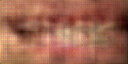

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(x_norm[0])

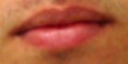

In [ ]:
cv2_imshow(xtest[0])

In [ ]:
x_norm[6][3][4][0]

100.98677

In [ ]:
totalAcc = 0
mae = 0
for img in range(len(x_norm)):
  sumY = 0
  sumPred = 0
  for i in range(len(x_norm[img])):
    for j in range(len(x_norm[img][i])):
      for k in range(len(x_norm[img][i][j])):
        sumY = sumY+xtest[img][i][j][k]
        sumPred = sumPred+x_norm[img][i][j][k]
  error = np.abs(sumPred-sumY)
  diff = np.abs(1-(sumPred/sumY))
  acc = (1-diff)*100
  totalAcc = totalAcc+acc
  mae = mae + error
print("final acc ",totalAcc/len(x_norm))
print("mae ",mae/len(x_norm))


final acc  87.31913072870321
mae  456990.37450632267


In [ ]:
len(hist1)

256

In [ ]:
# Load the images
#image1 = cv2.imread(x_norm[0])
#image2 = cv2.imread(xtest[0])

# Convert images to grayscale (if necessary)
gray1 = cv2.cvtColor(x_norm[0], cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(xtest[0], cv2.COLOR_BGR2GRAY)

# Calculate histograms
hist1 = cv2.calcHist([gray1], [0], None, [256], [0, 256])
hist2 = cv2.calcHist([gray2], [0], None, [256], [0, 256])

# Calculate histogram intersection
intersection = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)

print(f"Histogram Intersection: {intersection/len(hist1)}")

Histogram Intersection: 26.01953125


In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
(score, diff) = compare_ssim(xtest, predY, full=True, channel_axis=-1, win_size=7, gaussian_weights=True)
(score)

3.8350012e-05

In [ ]:
np.square(np.subtract(xtest, predY)).mean()

16586.387

In [ ]:
from sklearn.metrics import mean_squared_error
mse = []
for i in range(len(xtest)):
  mse[i] = mean_squared_error(xtest[i], predY[i])
  print("MSE for ",i,": ",mse[i])
total_mse = np.mean(mse)
total_mse

ValueError: ignored

In [ ]:
np.max(x_norm)

255.0

In [ ]:
metric = tensorflow.keras.metrics.Accuracy()
metric.update_state(xtest*255.0,predY*255.0)
metric.result().numpy()

0.0

In [ ]:
true_values = np.array(xtest)
predictions = np.array(predY)

N = true_values.shape[1]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
precision = TP / (TP+FP)

<ipython-input-25-8a797f1eb40d>:8: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP+FP)


In [ ]:
true_values.shape

(40, 64, 128, 3)

In [ ]:
history = model.fit(xtrain,ytrain, batch_size=64,
               steps_per_epoch=xtrain.shape[0]/64,
               epochs=5000,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_split = 0.1)

Streaming output truncated to the last 5000 lines.
Epoch 3751/5000

Epoch 3751: val_loss did not improve from 1258.60291
3/3 - 0s - loss: 1341.6891 - accuracy: 0.6920 - val_loss: 1259.4441 - val_accuracy: 0.6400 - lr: 0.0010 - 307ms/epoch - 79ms/step
Epoch 3752/5000

Epoch 3752: val_loss did not improve from 1258.60291
3/3 - 0s - loss: 1341.7415 - accuracy: 0.6741 - val_loss: 1259.4033 - val_accuracy: 0.6400 - lr: 0.0010 - 311ms/epoch - 80ms/step
Epoch 3753/5000

Epoch 3753: val_loss did not improve from 1258.60291
3/3 - 0s - loss: 1341.7178 - accuracy: 0.6696 - val_loss: 1259.3414 - val_accuracy: 0.6400 - lr: 0.0010 - 282ms/epoch - 72ms/step
Epoch 3754/5000

Epoch 3754: val_loss did not improve from 1258.60291
3/3 - 0s - loss: 1341.8707 - accuracy: 0.6161 - val_loss: 1259.3386 - val_accuracy: 0.6400 - lr: 0.0010 - 309ms/epoch - 80ms/step
Epoch 3755/5000

Epoch 3755: val_loss did not improve from 1258.60291
3/3 - 0s - loss: 1341.4025 - accuracy: 0.6607 - val_loss: 1259.2538 - val_accur

In [ ]:
model.save_weights(checkpoint_path)